<a href="https://colab.research.google.com/github/raj26000/Python-and-Machine-Learning/blob/main/Loan_Eligibility_Prediction_(AV).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# I. Importing Libraries and Loading Data

In [96]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, make_scorer
from google.colab import files

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [66]:
train_path = '/content/drive/MyDrive/train_ctrUa4K.csv'
test_path = '/content/drive/MyDrive/test_lAUu6dG.csv'
train_data = pd.read_csv(train_path)
test_data = pd.read_csv(test_path)
train_data

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y
...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,LP002978,Female,No,0,Graduate,No,2900,0.0,71.0,360.0,1.0,Rural,Y
610,LP002979,Male,Yes,3+,Graduate,No,4106,0.0,40.0,180.0,1.0,Rural,Y
611,LP002983,Male,Yes,1,Graduate,No,8072,240.0,253.0,360.0,1.0,Urban,Y
612,LP002984,Male,Yes,2,Graduate,No,7583,0.0,187.0,360.0,1.0,Urban,Y


# II. Data Preprocessing and EDA

In [67]:
#Checking for missing values in training and testing data
print(train_data.isnull().sum())
print(test_data.isnull().sum())

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64
Loan_ID               0
Gender               11
Married               0
Dependents           10
Education             0
Self_Employed        23
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount            5
Loan_Amount_Term      6
Credit_History       29
Property_Area         0
dtype: int64


In [68]:
#Imputing categorical missing values with mode and numerical ones with mean. 
#Since, percentage of missing values across all columns is small, no columns are dropped.
train_data['Gender'].fillna(train_data['Gender'].mode()[0], inplace=True)
train_data['Married'].fillna(train_data['Married'].mode()[0], inplace=True)
train_data['Dependents'].fillna(train_data['Dependents'].mode()[0], inplace=True)
train_data['Self_Employed'].fillna(train_data['Self_Employed'].mode()[0], inplace=True)
train_data['LoanAmount'].fillna(train_data['LoanAmount'].mean(), inplace=True)
train_data['Loan_Amount_Term'].fillna(train_data['Loan_Amount_Term'].mean(), inplace=True)
train_data['Credit_History'].fillna(train_data['Credit_History'].mode()[0], inplace=True)

test_data['Gender'].fillna(test_data['Gender'].mode()[0], inplace=True)
test_data['Dependents'].fillna(test_data['Dependents'].mode()[0], inplace=True)
test_data['Self_Employed'].fillna(test_data['Self_Employed'].mode()[0], inplace=True)
test_data['LoanAmount'].fillna(test_data['LoanAmount'].mean(), inplace=True)
test_data['Loan_Amount_Term'].fillna(test_data['Loan_Amount_Term'].mean(), inplace=True)
test_data['Credit_History'].fillna(test_data['Credit_History'].mode()[0], inplace=True)

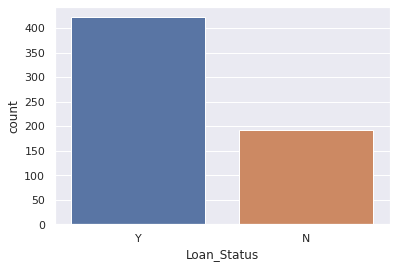

In [69]:
#Exploratory Data Analysis on training data
#Countplots for categorical features
sns.set_theme()
sns.countplot(x=train_data['Loan_Status'])

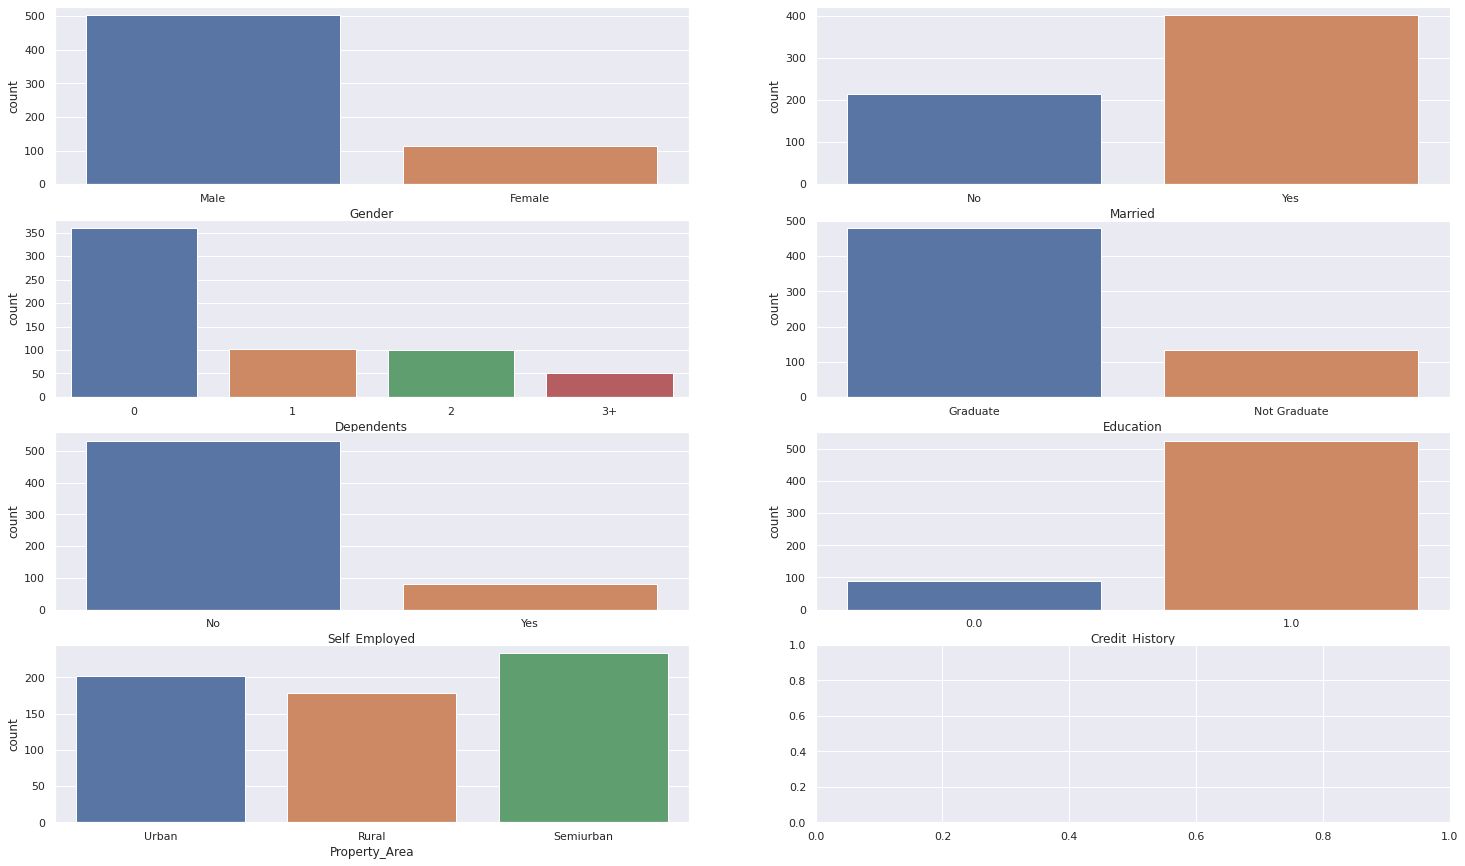

In [70]:
categorical = ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Credit_History', 'Property_Area']
fig, ax = plt.subplots(4,2,figsize=(25,15))
for var, subplot in zip(categorical, ax.flatten()):
  sns.countplot(x=train_data[var], ax=subplot)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa884e1dc50>,
      dtype=object)

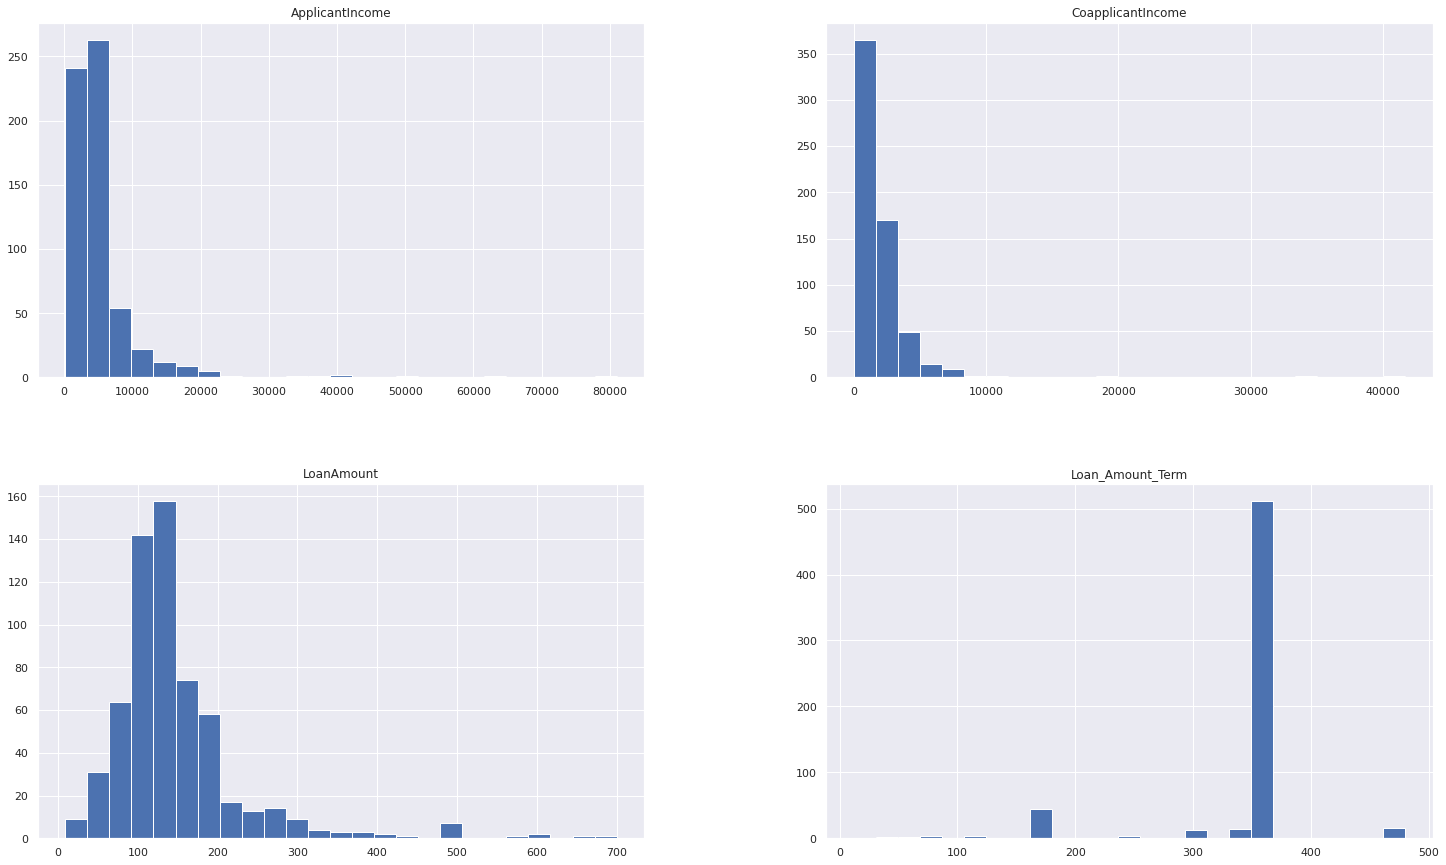

In [71]:
#Histograms for numerical features.
numerical = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term']
train_data[numerical].hist(bins=25, figsize=(25,15), layout=(2,2))

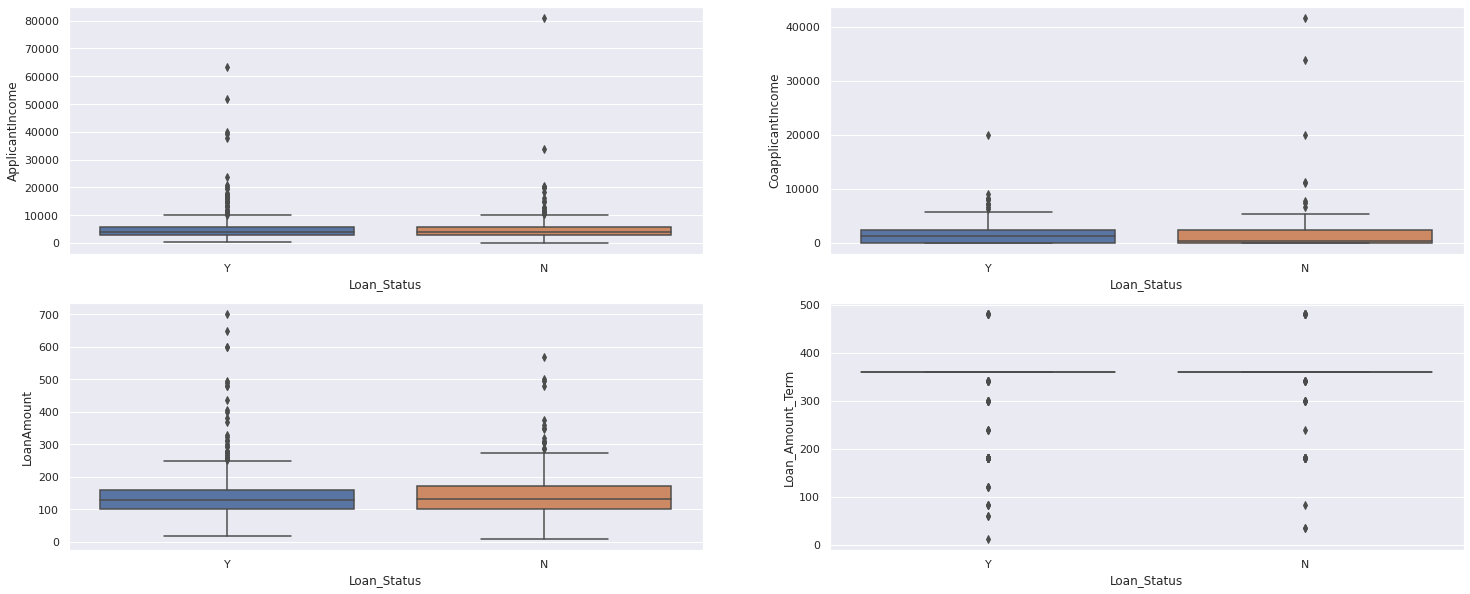

In [72]:
#Boxplots for showing relationship between numerical variables and categorical target variable
fig, ax = plt.subplots(2,2,figsize=(25,10))
for var, subplot in zip(numerical, ax.flatten()):
  sns.boxplot(x=train_data['Loan_Status'], y=train_data[var], ax=subplot)
#Small interquartile range of boxplot indicates a restricted range of values for numerical variables.

In [73]:
#Encoding categorical variables. Some of them are binary features, while those with multiple categories are ordinal features, hence no need of dummy encoding.
encoder = LabelEncoder()
for feature in categorical:
  train_data[feature] = encoder.fit_transform(train_data[feature])
  test_data[feature] = encoder.fit_transform(test_data[feature])
train_data['Loan_Status'] = encoder.fit_transform(train_data['Loan_Status'])

#Scaling numerical variables as: x = (x-min)/(max-min)
X_train = pd.DataFrame()
X_test = pd.DataFrame()
for col in numerical:
  X_train[col] = train_data[col]
  X_test[col] = test_data[col]
y_train = train_data.iloc[:,-1]
scaler = MinMaxScaler()
train_sc = scaler.fit_transform(X_train)
test_sc = scaler.transform(X_test)
X_train = pd.DataFrame(data=train_sc, columns=numerical)
X_test = pd.DataFrame(data=test_sc, columns=numerical)
for col in categorical:
  X_train[col] = train_data[col]
  X_test[col] = test_data[col]

# III. Model Training

In [86]:
#Training RandomForest Classifier, with GridSearch Cross validation
clf = RandomForestClassifier()
param_grid = {'n_estimators':[100,200,300], 'criterion':['gini','entropy'], 'max_depth':[20,30,None], 'min_samples_split':[2,3,4]}
grid = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5, n_jobs=-1, scoring=make_scorer(roc_auc_score))
cv_res = grid.fit(X_train, y_train)
print(cv_res.cv_results_)
print(cv_res.best_params_)

{'mean_fit_time': array([0.28592191, 0.5466939 , 0.80561337, 0.26809402, 0.53924737,
       0.80401893, 0.26659994, 0.5375771 , 0.81198134, 0.27508955,
       0.54914379, 0.81392632, 0.274752  , 0.55511332, 0.81999431,
       0.27395568, 0.55145273, 0.79909678, 0.27375584, 0.54120874,
       0.81164436, 0.27677336, 0.53625393, 0.8190074 , 0.26824818,
       0.53689814, 0.79830537, 0.30753613, 0.60725842, 0.91430211,
       0.30985284, 0.604286  , 0.91107635, 0.31205668, 0.60327005,
       0.9033134 , 0.30634713, 0.62070785, 0.92493491, 0.30696869,
       0.60600643, 0.90766625, 0.30281687, 0.61535463, 0.90523739,
       0.3040061 , 0.61081696, 0.91004848, 0.30467644, 0.61579218,
       0.91929941, 0.29989629, 0.60481472, 0.85555096]), 'std_fit_time': array([0.02378256, 0.01455585, 0.0106507 , 0.00161259, 0.0067504 ,
       0.00531797, 0.00410273, 0.00497192, 0.01300898, 0.00541667,
       0.0151637 , 0.00815094, 0.00522791, 0.01462212, 0.01087392,
       0.00591588, 0.02118943, 0.00702

In [95]:
#best_clf = cv_res.best_estimator_
best_clf = RandomForestClassifier(n_estimators=100, criterion='entropy', max_depth=20, min_samples_split=3)
best_clf.fit(X_train, y_train)
y_pred = best_clf.predict(X_test)
y_pred_labels = []
for i in range(0,len(y_pred)):
  if y_pred[i]==1:
    y_pred_labels.append('Y')
  else:
    y_pred_labels.append('N')
df = pd.DataFrame()
df['Loan_ID'] = test_data['Loan_ID']
df['Loan_Status'] = y_pred_labels
df.to_csv('Output.csv', index=False)
files.download('Output.csv')

#Result: Accuracy on test data - 0.76-0.78 depending on hyperparameter combinations

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [97]:
#Training XGBoost Classifier with GridSearch Cross Validation
clf = XGBClassifier(learning_rate=0.1)
param_grid = {'n_estimators':[50,75,100], 'max_depth':[2,3,5]}
grid = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5, n_jobs=-1, scoring=make_scorer(roc_auc_score))
cv_res = grid.fit(X_train, y_train)
print(cv_res.cv_results_)
print(cv_res.best_params_)

{'mean_fit_time': array([0.08116207, 0.04152112, 0.04998646, 0.03809557, 0.0515933 ,
       0.0614881 , 0.05032926, 0.06771421, 0.08670244]), 'std_fit_time': array([0.06175794, 0.00297393, 0.0021969 , 0.00303776, 0.00655459,
       0.00058682, 0.003034  , 0.00060902, 0.00057249]), 'mean_score_time': array([0.00466266, 0.00364895, 0.00373807, 0.00430813, 0.00380473,
       0.00395412, 0.00355439, 0.00372005, 0.00382848]), 'std_score_time': array([1.18859634e-03, 2.39535880e-04, 2.44962326e-04, 9.61838344e-04,
       1.51696162e-04, 1.84485234e-04, 7.93681663e-05, 1.22037060e-04,
       4.48891684e-04]), 'param_max_depth': masked_array(data=[2, 2, 2, 3, 3, 3, 5, 5, 5],
             mask=[False, False, False, False, False, False, False, False,
                   False],
       fill_value='?',
            dtype=object), 'param_n_estimators': masked_array(data=[50, 75, 100, 50, 75, 100, 50, 75, 100],
             mask=[False, False, False, False, False, False, False, False,
                

In [102]:
best_clf = cv_res.best_estimator_
#best_clf = RandomForestClassifier(n_estimators=100, criterion='entropy', max_depth=20, min_samples_split=3)
best_clf.fit(X_train, y_train)
y_pred = best_clf.predict(X_test)
y_pred_labels = []
for i in range(0,len(y_pred)):
  if y_pred[i]==1:
    y_pred_labels.append('Y')
  else:
    y_pred_labels.append('N')
df = pd.DataFrame()
df['Loan_ID'] = test_data['Loan_ID']
df['Loan_Status'] = y_pred_labels
df.to_csv('Output.csv', index=False)
files.download('Output.csv')

#Result: Accuracy on leaderboard test data = 0.7986

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>